Let's perform a full profile likelihood fit using toy data!

We will be using the same dataset as was used in the ml introduction exercise.

For simplicity, we will be only performing a fit with the Asimov MC data. 

But this can be trivially applied to real data as well - in fact it is computationally much cheaper. Can you guess why?

In [208]:
import numpy as np
import jax.numpy as jnp
from jax import jit
import pandas as pd
import jax

# I converted the root dataset to a dataframe for simplicity 
df_WW = pd.read_hdf('./data_WW_wPred_wSyst.h5', key='dataset')

# Extract the signal and background: label 1 -> Signal, label 0 -> Bkg
df_WW_Sig = df_WW[df_WW.label==1]
df_WW_Bkg = df_WW[df_WW.label==0]

In [209]:
import numpy as np

# I stored the BDT outputs for each entry in the dataset. Let us now extract them
obs_sig = df_WW_Sig.BDT_pred.ravel()
obs_bkg = df_WW_Bkg.BDT_pred.ravel()

# Fill Histograms

xmin = np.amin(obs_bkg)
xmax = np.amax(obs_sig)

bins = np.linspace(xmin, xmax, num=10)

hist_sig, _ = np.histogram(obs_sig, bins, weights=df_WW_Sig.mcWeight)     # Note how we fill the histogram with MC weights
hist_bkg, _ = np.histogram(obs_bkg, bins, weights=df_WW_Bkg.mcWeight)

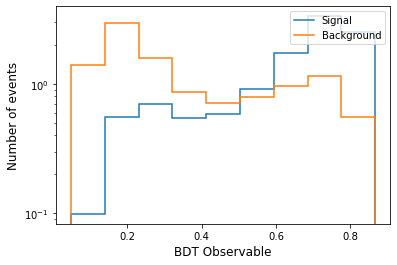

In [211]:
# To see better the separation power of the discriminant, we can also plot the normalized histograms

import mplhep as hep
from matplotlib import pyplot as plt

hep.histplot(hist_sig, bins, label='Signal', density=1)
hep.histplot(hist_bkg, bins, label='Background', density=1)

plt.xlabel('BDT Observable', size=12)
plt.ylabel('Number of events', size=12)
plt.legend(loc='upper right')
plt.yscale('log')

In [214]:
# The so called Asimov expected events (the exact number of events we would expect to observe if the 
# nominal mu=1 hypothesis is correct)

N_obs_Asimov = hist_sig + hist_bkg

print("The expected number of events in each bin of the discriminant: \n")
print(N_obs_Asimov)


The expected number of events in each bin of the discriminant: 

[ 81.44700434 173.27195032  94.42159246  51.71184839  42.99699869
  47.76060627  59.97951239  73.95018394  37.93186379]


<br>

In [225]:
# The polynomial part of the equation above - no need to be bogged down with the details here
def poly_interp(alpha, varUp, varDown, varNom):
    
    # Calculate the co-efficients a_i 
    pow_up = jnp.divide(varUp,varNom)
    pow_down = jnp.divide(varDown,varNom)
    logHi = jnp.log(jnp.clip(pow_up,1e-7,None))
    logLo = jnp.log(jnp.clip(pow_down,1e-7,None))
    logHi = jnp.log(pow_up)
    logLo = jnp.log(pow_down)
    pow_up_log = jnp.multiply(pow_up,logHi)
    pow_down_log = -jnp.multiply(pow_down,logLo)
    pow_up_log2 = jnp.multiply(pow_up_log,logHi)
    pow_down_log2 = -jnp.multiply(pow_down_log,logLo)
    
    S0 = (pow_up+pow_down)/2.0
    A0 = (pow_up-pow_down)/2.0
    S1 = (pow_up_log+pow_down_log)/2.0
    A1 = (pow_up_log-pow_down_log)/2.0
    S2 = (pow_up_log2+pow_down_log2)/2.0
    A2 = (pow_up_log2-pow_down_log2)/2.0
 
    a1 = (15*A0-7*S1+A2)/8.0
    a2 = (-24+24*S0-9*A1+S2)/8.0
    a3 = (-5*A0+5*S1-A2)/4.0
    a4 = (12-12*S0+7*A1-S2)/4.0
    a5 = (3*A0-3*S1+A2)/8.0
    a6 = (-8+8*S0-5*A1+S2)/8.0

    return 1.0 + alpha * (a1 + alpha * ( a2 + alpha * ( a3 + alpha * ( a4 + alpha * ( a5 + alpha * a6 ) ) ) ) )
    

# The exponential part of the equation above - for extrapolation
def exp_interp(alpha, varUp, varDown, varNom):
    
    return jnp.where(alpha>1.0, (varUp/varNom)**alpha, (varDown/varNom)**(-alpha))


# Calculate the net yield, but now with systematic NP modif-iable histograms
def sigma(mu, hist_sig, hist_bkg, fact_sig, fact_big):
    
    sigma_mu_binned = mu*hist_sig*fact_sig + hist_bkg*fact_big
                        
    return sigma_mu_binned


<br>

In [226]:
# Let's extract the systematic variations (start with only signal so you can follow the code)

NP_size = 100

arr_ratio_up_sig = [[1.0 for i in range(len(hist_sig))] for j in range(NP_size)]
arr_ratio_down_sig = [[1.0 for i in range(len(hist_sig))] for j in range(NP_size)]

for count in range(NP_size):
    
    systematic_name = 'syst_'+str(count)
    
    # Calculate the net weight variations for each of the systematics
    weight_up_sig = df_WW_Sig[systematic_name+'_up']*df_WW_Sig['mcWeight']
    weight_down_sig = df_WW_Sig[systematic_name+'_down']*df_WW_Sig['mcWeight']
    
    # Re-fill the histogram with new weights
    hist_sig_up, _ = np.histogram(obs_sig, bins, weights=weight_up_sig)
    hist_sig_down, _ = np.histogram(obs_sig, bins, weights=weight_down_sig)
    
    
    # Extract the up and down variations as a function of the discriminant histogram bins
    arr_ratio_up_sig[count] = jnp.array(1.0+(hist_sig_up - hist_sig))
    arr_ratio_down_sig[count] = jnp.array(1.0+(hist_sig_down - hist_sig))

print(arr_ratio_up_sig[0])
print(arr_ratio_down_sig[0])

[0.9998705  0.9998039  0.9999116  0.9993403  1.0002856  0.99999976
 1.0002211  0.9991625  0.99662024]
[1.0001296  1.0001961  1.0000883  1.0006597  0.99971443 1.0000002
 0.99977887 1.0008374  1.0033798 ]


<br>

In [227]:
# Let's do the same for bkg

arr_ratio_up_bkg = [[1.0 for i in range(len(hist_bkg))] for j in range(NP_size)]
arr_ratio_down_bkg = [[1.0 for i in range(len(hist_bkg))] for j in range(NP_size)]

for count in range(NP_size):
    
    systematic_name = 'syst_'+str(count)
    
    weight_up_bkg = df_WW_Bkg[systematic_name+'_up'].ravel()*df_WW_Bkg.mcWeight.ravel()
    weight_down_bkg = df_WW_Bkg[systematic_name+'_down'].ravel()*df_WW_Bkg.mcWeight.ravel()

    hist_bkg_up, _ = np.histogram(obs_bkg, bins, weights=weight_up_bkg)
    hist_bkg_down, _ = np.histogram(obs_bkg, bins, weights=weight_down_bkg)
    
    arr_ratio_up_bkg[count] = jnp.array(1.0+(hist_bkg_up - hist_bkg))
    arr_ratio_down_bkg[count] = jnp.array((1.0+(hist_bkg_down - hist_bkg)))
    
print(arr_ratio_down_bkg[0])

[0.9598521  1.0378022  1.0267143  0.9754182  0.99556535 0.9904194
 0.95348173 0.9310182  1.0161703 ]


<br>

In [228]:
# Convert everything to JAX numpy arrays
N_obs_Asimov = jnp.array(N_obs_Asimov)

hist_sig = jnp.array(hist_sig)
hist_bkg = jnp.array(hist_bkg)

<br>

In [229]:
# Re-define the function to take into account systematic variations
def NLL(param_array, hist_sig, arr_ratio_up_sig, arr_ratio_down_sig, arr_ratio_up_bkg, arr_ratio_down_bkg, hist_bkg, N_obs_Asimov):
    
    mu = param_array[0]
    
    # Initialize the modification arrays
    fact_sig = jnp.ones_like(hist_sig)
    fact_bkg = jnp.ones_like(hist_sig)
    
    for n in range(1, param_array.shape[0]):
         
        # Find the modification factor for any value of parameter based on interpolation techniques
        fact_sig *= jnp.where(jnp.abs(param_array[n])<=1.0, poly_interp(param_array[n], arr_ratio_up_sig[n-1], arr_ratio_down_sig[n-1], 1.0),exp_interp(param_array[n], arr_ratio_up_sig[n-1], arr_ratio_down_sig[n-1], 1.0))   
        fact_bkg *= jnp.where(jnp.abs(param_array[n])<=1.0, poly_interp(param_array[n], arr_ratio_up_bkg[n-1], arr_ratio_down_bkg[n-1], 1.0),exp_interp(param_array[n], arr_ratio_up_bkg[n-1], arr_ratio_down_bkg[n-1], 1.0))      

    sigma_mu = sigma(mu, hist_sig, hist_bkg, fact_sig, fact_bkg)
    
    # Notice the last term coming from the log of subsidiary likelihood 
    llr = jnp.array([-2*N_obs_Asimov*jnp.log(sigma_mu)+2*sigma_mu]).sum() + jnp.sum(param_array[1:]**2)
        
    return llr



def NLL_minuit(param_array):
    
    return NLL(param_array, hist_sig, arr_ratio_up_sig, arr_ratio_down_sig, arr_ratio_up_bkg, arr_ratio_down_bkg, hist_bkg, N_obs_Asimov)



<br>

In [235]:
%%timeit -n1 -r1

# Re-do the fit with 20 NPs

tuple_syst = [0.0] * (101) 
tuple_syst[0] = 1.0 

list_names = ['syst_'+str(i) for i in range(len(tuple_syst)-1)]
list_names.insert(0, 'mu')
print(str(list_names)+'\n')

# Convert to JAX array
tuple_syst = jnp.array(tuple_syst, dtype='float32')

# JITT-ed NLL_minuit function
m1 = Minuit(jax.jit(NLL_minuit), tuple(tuple_syst), grad=None, name=tuple(list_names))
m1.precision = 1e-7
m1.errordef = Minuit.LEAST_SQUARES
m1.strategy = 2
m1.migrad()

['mu', 'syst_0', 'syst_1', 'syst_2', 'syst_3', 'syst_4', 'syst_5', 'syst_6', 'syst_7', 'syst_8', 'syst_9', 'syst_10', 'syst_11', 'syst_12', 'syst_13', 'syst_14', 'syst_15', 'syst_16', 'syst_17', 'syst_18', 'syst_19', 'syst_20', 'syst_21', 'syst_22', 'syst_23', 'syst_24', 'syst_25', 'syst_26', 'syst_27', 'syst_28', 'syst_29', 'syst_30', 'syst_31', 'syst_32', 'syst_33', 'syst_34', 'syst_35', 'syst_36', 'syst_37', 'syst_38', 'syst_39', 'syst_40', 'syst_41', 'syst_42', 'syst_43', 'syst_44', 'syst_45', 'syst_46', 'syst_47', 'syst_48', 'syst_49', 'syst_50', 'syst_51', 'syst_52', 'syst_53', 'syst_54', 'syst_55', 'syst_56', 'syst_57', 'syst_58', 'syst_59', 'syst_60', 'syst_61', 'syst_62', 'syst_63', 'syst_64', 'syst_65', 'syst_66', 'syst_67', 'syst_68', 'syst_69', 'syst_70', 'syst_71', 'syst_72', 'syst_73', 'syst_74', 'syst_75', 'syst_76', 'syst_77', 'syst_78', 'syst_79', 'syst_80', 'syst_81', 'syst_82', 'syst_83', 'syst_84', 'syst_85', 'syst_86', 'syst_87', 'syst_88', 'syst_89', 'syst_90', 's

<br>

In [236]:

tuple_syst = [0.0] * (2) 
tuple_syst[0] = 1.0 

# Define a list of names to keep track of - normally these are stored in the dataset
list_names = ['syst_'+str(i) for i in range(len(tuple_syst)-1)]
list_names.insert(0, 'mu')
print(list_names)

# Convert to JAX array
tuple_syst = jnp.array(tuple_syst, dtype='float32')

print(jax.make_jaxpr(jax.jit(NLL_minuit))(tuple_syst))

['mu', 'syst_0']
{ lambda a:f32[9] b:f32[9] c:f32[9] d:f32[9] e:f32[9] f:f32[9] g:f32[9]; h:f32[2]. let
    i:f32[] = xla_call[
      call_jaxpr={ lambda ; j:f32[9] k:f32[9] l:f32[9] m:f32[9] n:f32[9] o:f32[9]
          p:f32[9] q:f32[2]. let
          r:bool[] = lt 0 0
          s:i32[] = add 0 2
          t:i32[] = select_n r 0 s
          u:i32[1] = broadcast_in_dim[broadcast_dimensions=() shape=(1,)] t
          v:f32[] = gather[
            dimension_numbers=GatherDimensionNumbers(offset_dims=(), collapsed_slice_dims=(0,), start_index_map=(0,))
            fill_value=None
            indices_are_sorted=True
            mode=GatherScatterMode.PROMISE_IN_BOUNDS
            slice_sizes=(1,)
            unique_indices=True
          ] q u
          w:f32[9] = broadcast_in_dim[broadcast_dimensions=() shape=(9,)] 1.0
          x:f32[9] = broadcast_in_dim[broadcast_dimensions=() shape=(9,)] 1.0
          y:bool[] = lt 1 0
          z:i32[] = add 1 2
          ba:i32[] = select_n y 1 z
  